# 04 - Public Good Score

Combine all criteria into a final Public Good Index score per state.

## Methodology (inspired by CPI)

1. **Normalize** each sub-metric using z-scores:
   - `z = (value - mean) / std_dev`
   - Rescale to 0–100 (mean ~45, std_dev ~20, clamped to [0, 100])

2. **Sub-metrics** (all oriented so higher = better public good):
   - Tax efficiency: inverse of tax burden (lower taxes = higher score)
   - Investment ratio: % of spending classified as investment
   - Service effectiveness: composite of outcome metrics

3. **Aggregate**: simple average of normalized sub-scores

Score of 100 = low taxes, high investment ratio, great outcomes
Score of 0 = high taxes, mostly cost spending, poor outcomes

**Output:** `public_good_scores.json` for D3 charts

In [1]:
import sys
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.insert(0, str(Path("..").resolve()))
from src.data_utils import get_col_weights

PROCESSED_DIR = Path("../data/processed")
CHARTS_DIR = Path("../docs/charts/data")
CHARTS_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
def normalize_zscore(series, invert=False):
    """Normalize a series to 0-100 using z-score method (CPI-style).
    
    Args:
        series: pandas Series of raw values
        invert: if True, higher raw values produce lower scores
                (use for metrics where lower is better, like tax burden)
    """
    if invert:
        series = -series
    z = (series - series.mean()) / series.std()
    # Rescale: mean=50, std=20 (centered at midpoint)
    scaled = z * 20 + 50
    return scaled.clip(0, 100)

In [3]:
# Load outputs from notebooks 01-03
tax_burden = pd.read_csv(PROCESSED_DIR / "tax_burden.csv")
spending = pd.read_csv(PROCESSED_DIR / "spending_breakdown.csv")
effectiveness = pd.read_csv(PROCESSED_DIR / "service_effectiveness.csv")

print(f"Tax burden:    {len(tax_burden)} states")
print(f"Spending:      {len(spending)} states")
print(f"Effectiveness: {len(effectiveness)} states")

Tax burden:    48 states
Spending:      48 states
Effectiveness: 51 states


In [ ]:
# Merge all sub-metrics on state
combined = tax_burden[["state", "state_name", "total_burden"]].merge(
    spending[["state", "investment_ratio"]], on="state", how="inner"
).merge(
    effectiveness[["state", "composite_z"]], on="state", how="inner"
)

# Normalize each sub-metric using z-scores (CPI-style, 0-100, centered at 50)
# All three inputs get exactly one z-score → 0-100 transformation
combined["tax_score"] = normalize_zscore(combined["total_burden"], invert=True)
combined["investment_score"] = normalize_zscore(combined["investment_ratio"])
combined["effectiveness_score"] = normalize_zscore(combined["composite_z"])

# Calculate Public Good Index = simple average of three scores
combined["public_good_index"] = (
    combined["tax_score"]
    + combined["investment_score"]
    + combined["effectiveness_score"]
) / 3

# Rank states (1 = best)
combined["rank"] = combined["public_good_index"].rank(ascending=False).astype(int)

print(f"States: {len(combined)}")
print(f"Public Good Index range: {combined['public_good_index'].min():.1f}/100 – "
      f"{combined['public_good_index'].max():.1f}/100")
print(f"Mean: {combined['public_good_index'].mean():.1f}/100, "
      f"Median: {combined['public_good_index'].median():.1f}/100")

# Display with formatted scores
display_df = combined[["state", "state_name", "rank", "tax_score", "investment_score",
                        "effectiveness_score", "public_good_index"]].copy()
for col in ["tax_score", "investment_score", "effectiveness_score", "public_good_index"]:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.1f}/100")
display_df.sort_values("rank").head(10)

In [ ]:
# Export results
# Summary scores
score_cols = ["state", "state_name", "rank", "tax_score", "investment_score",
              "effectiveness_score", "public_good_index"]
scores = combined[score_cols].sort_values("rank").reset_index(drop=True)

csv_path = PROCESSED_DIR / "public_good_scores.csv"
scores.to_csv(csv_path, index=False)
print(f"Wrote {csv_path}")

json_path = CHARTS_DIR / "public_good_scores.json"
scores.to_json(json_path, orient="records", indent=2)
print(f"Wrote {json_path}")

# Detailed output with raw values
detail_cols = ["state", "state_name", "rank", "total_burden", "investment_ratio",
               "composite_z", "tax_score", "investment_score",
               "effectiveness_score", "public_good_index"]
detailed = combined[detail_cols].sort_values("rank").reset_index(drop=True)
detail_path = PROCESSED_DIR / "public_good_detailed.csv"
detailed.to_csv(detail_path, index=False)
print(f"Wrote {detail_path}")

In [ ]:
# Dashboard visualization
from matplotlib.colors import LinearSegmentedColormap
SCORE_CMAP = LinearSegmentedColormap.from_list("score", ["#d32f2f", "#ff9800", "#fdd835", "#66bb6a", "#2e7d32"])

# 1. Ranking bar chart
fig, ax = plt.subplots(figsize=(14, 12))
plot_data = scores.sort_values("public_good_index", ascending=True)
colors = SCORE_CMAP(plot_data["public_good_index"] / 100)
ax.barh(plot_data["state"], plot_data["public_good_index"], color=colors)
ax.set_xlabel("Public Good Index (0-100)", fontsize=12)
ax.set_title("Public Good Index Ranking", fontsize=14)
ax.axvline(x=50, color="gray", linestyle="--", alpha=0.5, label="Expected Mean")
ax.tick_params(axis="y", labelsize=11)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

# 2. Component comparison (top/bottom 10)
fig, ax = plt.subplots(figsize=(14, 10))
top_bottom = pd.concat([scores.head(10), scores.tail(10)])
x = range(len(top_bottom))
w = 0.25
ax.barh([i - w for i in x], top_bottom["tax_score"], height=w, label="Tax", color="#1abc9c")
ax.barh(x, top_bottom["investment_score"], height=w, label="Investment", color="#e67e22")
ax.barh([i + w for i in x], top_bottom["effectiveness_score"], height=w, label="Effectiveness", color="#8e44ad")
ax.set_yticks(list(x))
ax.set_yticklabels(top_bottom["state"], fontsize=11)
ax.set_xlabel("Score (0-100)", fontsize=12)
ax.set_title("Component Scores: Top & Bottom 10", fontsize=14)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

# 3. Correlation matrix
fig, ax = plt.subplots(figsize=(8, 7))
corr_cols = ["tax_score", "investment_score", "effectiveness_score", "public_good_index"]
corr = combined[corr_cols].corr()
im = ax.imshow(corr, cmap="PuOr", vmin=-1, vmax=1)
ax.set_xticks(range(len(corr_cols)))
ax.set_yticks(range(len(corr_cols)))
labels = ["Tax", "Investment", "Effectiveness", "PGI"]
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticklabels(labels, fontsize=12)
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=11)
plt.colorbar(im, ax=ax, label="Correlation")
ax.set_title("Component Correlation Matrix", fontsize=14)
plt.tight_layout()
plt.show()

# 4. Histogram of PGI scores
fig, ax = plt.subplots(figsize=(14, 6))
ax.hist(scores["public_good_index"], bins=15, color="#8e44ad", edgecolor="white", alpha=0.8)
ax.axvline(x=scores["public_good_index"].mean(), color="#e67e22", linestyle="--", label="Mean")
ax.axvline(x=scores["public_good_index"].median(), color="#1abc9c", linestyle="--", label="Median")
ax.set_xlabel("Public Good Index (0-100)", fontsize=12)
ax.set_ylabel("Number of States", fontsize=12)
ax.set_title("Distribution of Public Good Index Scores", fontsize=14)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

In [7]:
import plotly.express as px

SCORE_SCALE = [[0, "#d32f2f"], [0.25, "#ff9800"], [0.5, "#fdd835"], [0.75, "#66bb6a"], [1, "#2e7d32"]]

fig = px.choropleth(
    scores,
    locations="state",
    locationmode="USA-states",
    color="public_good_index",
    color_continuous_scale=SCORE_SCALE,
    range_color=[0, 100],
    scope="usa",
    hover_name="state_name",
    hover_data={
        "state": False,
        "rank": True,
        "public_good_index": ":.1f",
        "tax_score": ":.1f",
        "investment_score": ":.1f",
        "effectiveness_score": ":.1f",
    },
    labels={
        "public_good_index": "PGI (0-100)",
        "tax_score": "Tax Score (0-100)",
        "investment_score": "Investment Score (0-100)",
        "effectiveness_score": "Effectiveness Score (0-100)",
    },
    title="Public Good Index — Overall Score",
)
fig.update_layout(
    coloraxis_colorbar=dict(title="PGI"),
    geo=dict(lakecolor="rgb(255,255,255)"),
)
fig.show()

In [8]:
# Subcategory maps — Tax, Investment, Effectiveness scores (stacked for mobile)
from plotly.subplots import make_subplots
import plotly.graph_objects as go

SCORE_SCALE = [[0, "#d32f2f"], [0.25, "#ff9800"], [0.5, "#fdd835"], [0.75, "#66bb6a"], [1, "#2e7d32"]]

fig = make_subplots(
    rows=3, cols=1,
    specs=[[{"type": "choropleth"}], [{"type": "choropleth"}], [{"type": "choropleth"}]],
    subplot_titles=["Tax Score (0-100)", "Investment Score (0-100)", "Effectiveness Score (0-100)"],
    vertical_spacing=0.02,
)

for i, (col, title) in enumerate([
    ("tax_score", "Tax"),
    ("investment_score", "Investment"),
    ("effectiveness_score", "Effectiveness"),
], start=1):
    fig.add_trace(go.Choropleth(
        locations=scores["state"],
        z=scores[col],
        locationmode="USA-states",
        colorscale=SCORE_SCALE,
        zmin=0, zmax=100,
        colorbar=dict(title=title, y=1.07 - i * 0.35, len=0.3),
        hovertext=scores["state_name"],
        hovertemplate="%{hovertext}<br>" + title + " Score: %{z:.1f}/100<extra></extra>",
    ), row=i, col=1)

fig.update_geos(scope="usa", lakecolor="rgb(255,255,255)")
fig.update_layout(title_text="Public Good Index — Component Scores", height=1100)
fig.show()

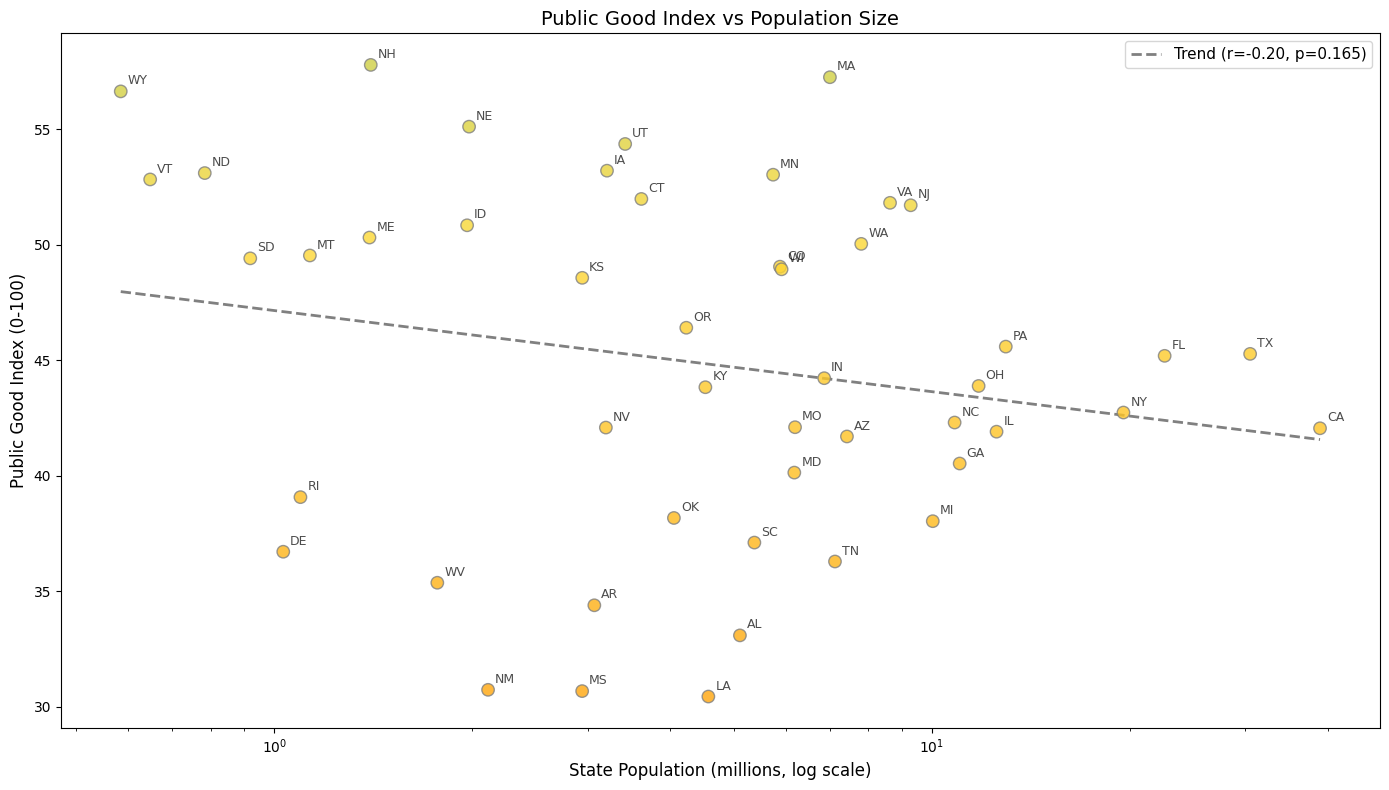

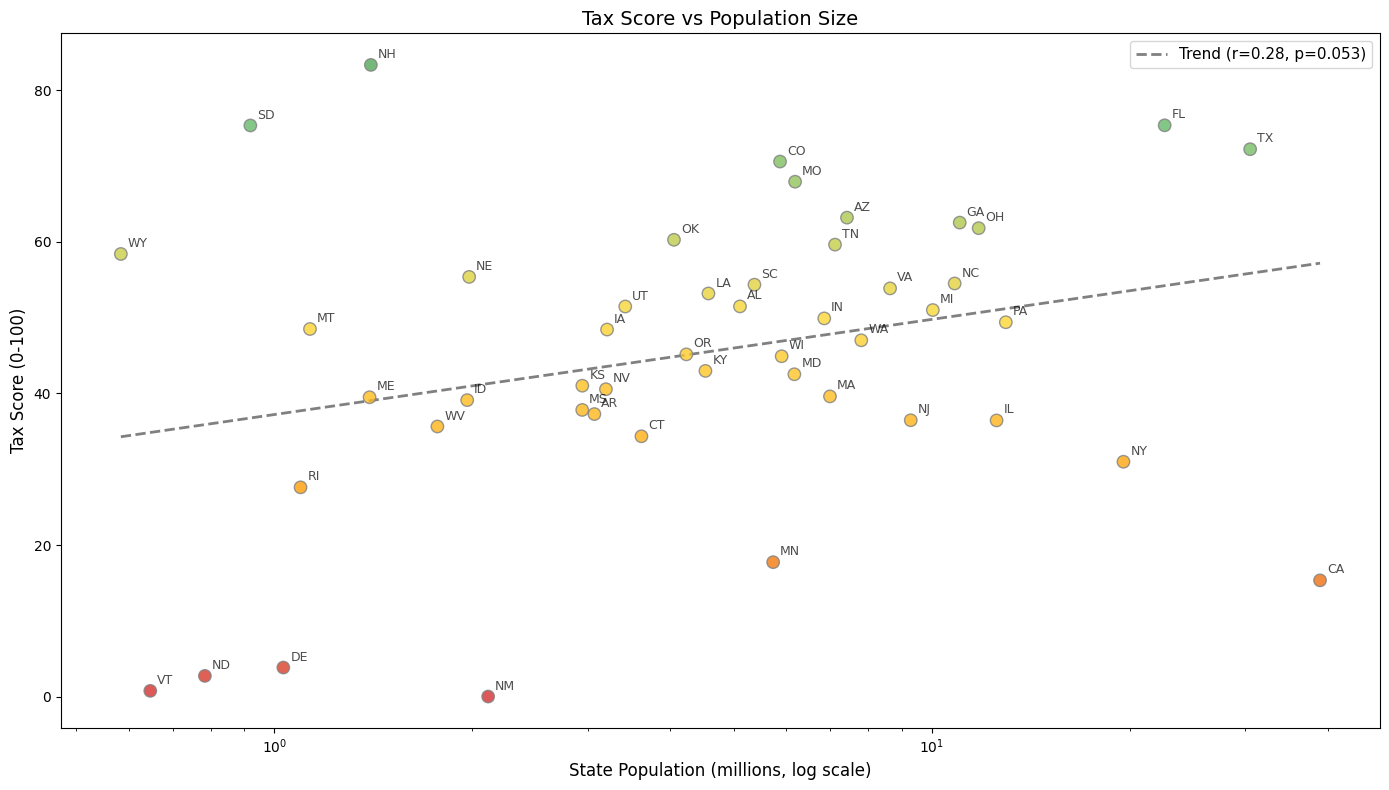

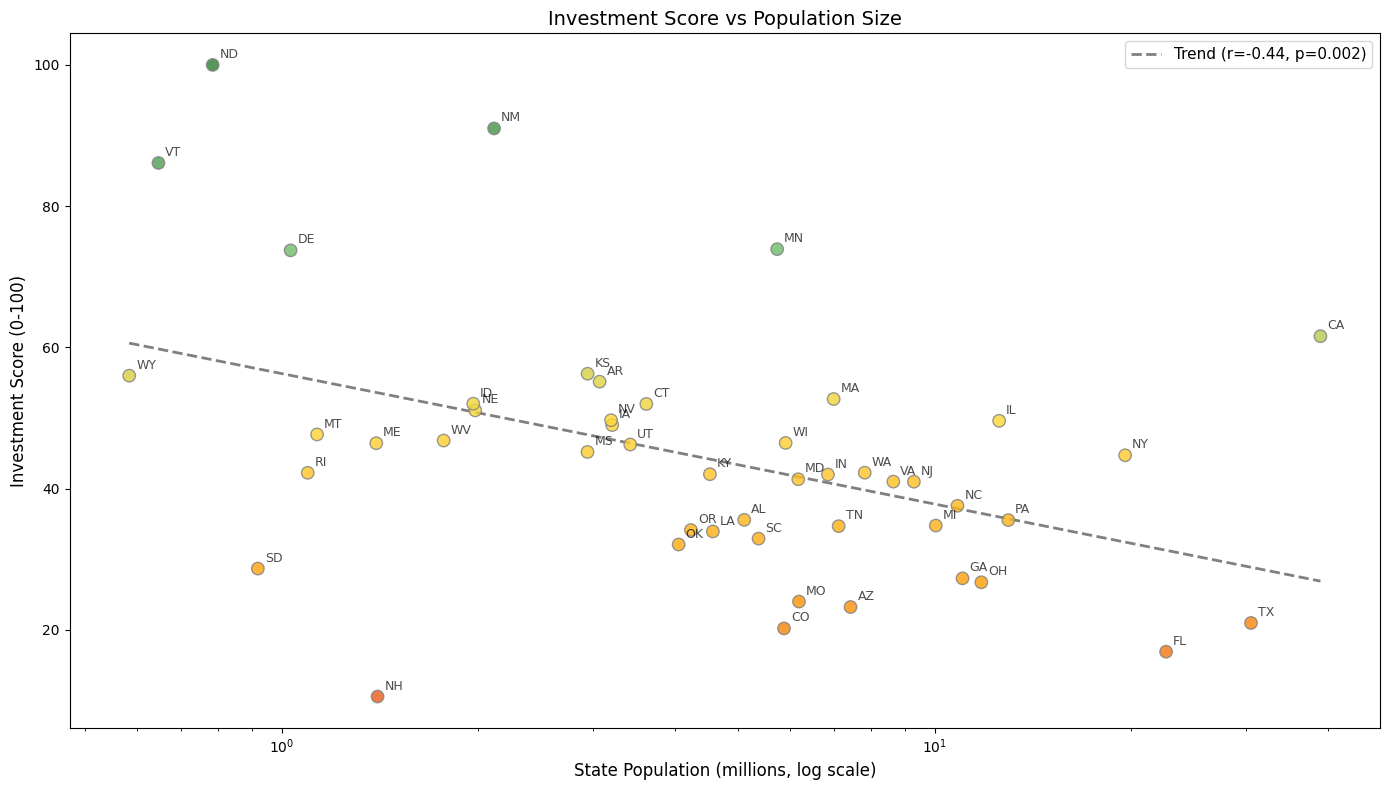

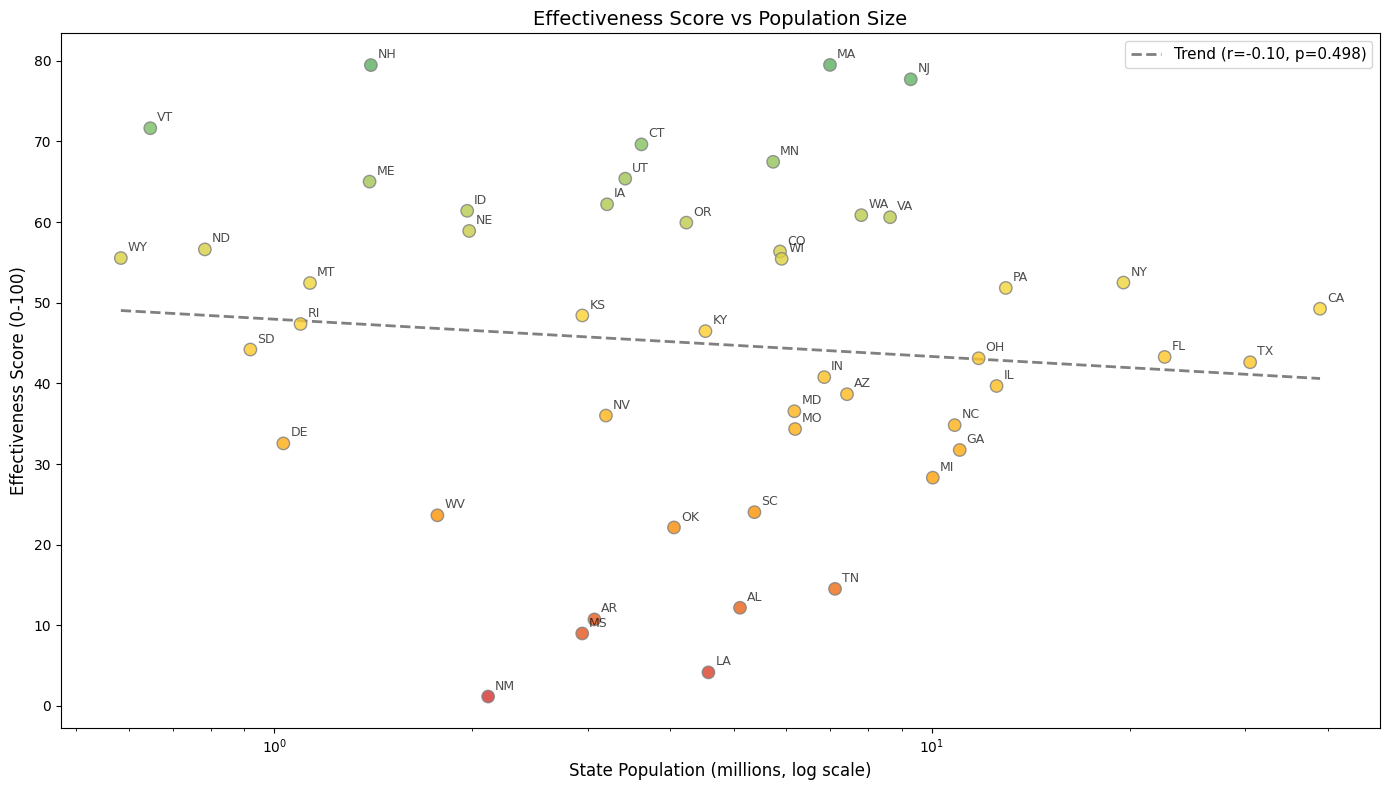

In [9]:
# Scatter plots — Population vs each score (with trend lines, log scale)
from scipy import stats

# Merge population into scores
pop_data = tax_burden[["state", "population"]].copy()
scatter_df = scores.merge(pop_data, on="state", how="left")
scatter_df["pop_millions"] = scatter_df["population"] / 1e6

score_cols = [
    ("public_good_index", "Public Good Index"),
    ("tax_score", "Tax Score"),
    ("investment_score", "Investment Score"),
    ("effectiveness_score", "Effectiveness Score"),
]

for col, label in score_cols:
    fig, ax = plt.subplots(figsize=(14, 8))

    ax.scatter(scatter_df["pop_millions"], scatter_df[col],
               c=scatter_df[col], cmap=SCORE_CMAP, s=80, alpha=0.8,
               edgecolors="gray", zorder=3, vmin=0, vmax=100)

    # Label each point
    for _, row in scatter_df.iterrows():
        ax.annotate(row["state"], (row["pop_millions"], row[col]),
                     fontsize=9, alpha=0.7, textcoords="offset points",
                     xytext=(5, 5))

    # Trend line (on log-transformed x)
    log_pop = np.log10(scatter_df["pop_millions"])
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_pop, scatter_df[col])
    x_line = np.logspace(np.log10(scatter_df["pop_millions"].min()),
                         np.log10(scatter_df["pop_millions"].max()), 100)
    ax.plot(x_line, slope * np.log10(x_line) + intercept, color="gray", linestyle="--",
            linewidth=2, label=f"Trend (r={r_value:.2f}, p={p_value:.3f})")

    ax.set_xscale("log")
    ax.set_xlabel("State Population (millions, log scale)", fontsize=12)
    ax.set_ylabel(f"{label} (0-100)", fontsize=12)
    ax.set_title(f"{label} vs Population Size", fontsize=14)
    ax.legend(fontsize=11)
    plt.tight_layout()
    plt.show()